# Training base expert on vanilla OGBench environment using BC

In [1]:
import random
import torch

import matplotlib.pyplot as plt

from collections import defaultdict

from causal_gym import AntMazePCH
from causal_rl.algo.imitation.imitate import *
from causal_rl.algo.imitation.finetune import *

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/et2842/miniconda3/envs/causalenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
num_steps = 1000
seed = 0
hidden_dims = set()

random.seed(seed)
torch.manual_seed(seed)

In [ ]:
env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=seed)
train_eps = env.expert.num_eps
train_eps

In [ ]:
X = {f'X{t}' for t in range(num_steps)}
Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [ ]:
Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

    for j in range(i):
        cond.add(f'X{j}')

    Z_sets[Xi] = cond

In [ ]:
records = collect_expert_trajectories(
    env,
    num_episodes=train_eps,
    max_steps=num_steps,
    seed=seed
)

In [ ]:
hidden_size = 256
lr = 3e-4
batch_size = 2048
patience = 15
lookback = 1
num_blocks = 4
epochs = 100
dropout = 0.0

dims = {
    'P': 3,
    'O': 4,
    'A': 8,
    'L': 3,
    'T': 3,
    'J': 8,
    'X': 8
}

In [ ]:
model, slots, Z_trim = train_single_policy_long_horizon(
    records,
    Z_sets,
    dims=dims,
    epochs=epochs,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

policy = shared_policy_fn_long_horizon(model, slots, Z_trim, continuous=True, device=device)
policies = make_shared_policy_dict(policy)

In [ ]:
expert_episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    expert_episode_rewards[ep] += float(rec['reward'])

num_eps = len(expert_episode_rewards)
expert_rewards = [expert_episode_rewards[e] for e in range(num_eps)]

policy_records = collect_imitator_trajectories(env, policies, num_episodes=num_eps, max_steps=num_steps, seed=seed)
policy_episode_rewards = defaultdict(float)
for rec in policy_records:
    ep = rec['episode']
    policy_episode_rewards[ep] += float(rec['reward'])

policy_rewards = [policy_episode_rewards[e] for e in range(num_eps)]
plt.figure(figsize=(8,5))
plt.plot(expert_rewards, label='Expert')
plt.plot(policy_rewards, label='Policy BC')
plt.xlabel('Episode')
plt.ylabel('Final Cumulative Reward')
plt.title('Comparison of Expert Dataset vs. BC Policy Returns')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
sum(expert_rewards)/num_eps, sum(policy_rewards)/num_eps

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

def get_episode_xy_from_records(records, episode_id: int):
    '''
    records: list of dicts from collect_expert_trajectories(...)
    episode_id: which episode to extract

    Returns:
        xs, ys : np.ndarray of shape (T,)
    '''
    # Filter records for that episode, sorted by step
    ep = [r for r in records if r['episode'] == episode_id]
    ep = sorted(ep, key=lambda r: r['step'])

    xs, ys = [], []
    for r in ep:
        # r['info']['hidden_obs']['P'] is a *history* list; last entry is current position
        pos = r['obs']['P'][-1]   # shape (3,)
        xs.append(pos[0])
        ys.append(pos[1])

    return np.array(xs), np.array(ys)

def plot_ant_trajectory_xy(records, episode_id: int = 0, ax=None, title_prefix='AntMaze'):
    '''
    Visualize the ant's 2D trajectory (x, y) for a single episode.

    - Path is colored by time (early=dark, late=bright).
    - Start and end are annotated.
    - Small arrows show direction every few steps.
    '''
    xs, ys = get_episode_xy_from_records(records, episode_id)
    T = len(xs)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Build a colored line collection for the path
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Time as color (0..1)
    t_norm = np.linspace(0, 1, T-1)
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
    lc.set_array(t_norm)
    lc.set_linewidth(2.5)
    ax.add_collection(lc)

    # Start and end markers
    ax.scatter(xs[0], xs[0], alpha=0)  # dummy to keep colors aligned if needed
    ax.scatter(xs[0], ys[0], s=80, c='green', marker='o', edgecolors='black', label='Start')
    ax.scatter(xs[-1], ys[-1], s=80, c='red', marker='X', edgecolors='black', label='End')

    # Small arrows every N steps to show direction
    step = max(1, T // 30)  # about ~30 arrows max
    for i in range(0, T-1, step):
        dx = xs[i+1] - xs[i]
        dy = ys[i+1] - ys[i]
        ax.arrow(xs[i], ys[i], dx, dy,
                 length_includes_head=True,
                 head_width=0.2,
                 head_length=0.4,
                 alpha=0.6)

    # Colorbar for time
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Time (normalized)')

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.set_title(f'{title_prefix} - Episode {episode_id} trajectory')
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    return fig, ax

In [ ]:
fig, ax = plot_ant_trajectory_xy(records, episode_id=0, title_prefix='Expert AntMaze')
plt.show()

In [ ]:
fig, ax = plot_ant_trajectory_xy(policy_records, episode_id=np.random.randint(0, 1102), title_prefix='Naive AntMaze')
plt.show()

In [ ]:
# # save model for fine-tuning
# import os
# import torch

# SAVE_DIR = '/home/et2842/causal/causalrl/models'
# os.makedirs(SAVE_DIR, exist_ok=True)
# MODEL_PATH = os.path.join(SAVE_DIR, 'antmaze_expert.pt')

# checkpoint = {
#     "state_dict": model.state_dict(),
#     "slots": slots,
#     "Z_trim": Z_trim,
#     "dims": dims,
#     "lookback": lookback,
#     "continuous": True,
#     "num_actions": env.action_space.shape[0],
#     "hidden_dim": hidden_size,
#     "num_blocks": num_blocks,
#     "dropout": 0.0,
#     "layernorm": True,
#     "final_tanh": True,
#     "action_bounds_low": env.action_space.low,
#     "action_bounds_high": env.action_space.high,
#     "input_dim": int(model.hidden.in_features),
# }

# torch.save(checkpoint, MODEL_PATH)
# print("Saved expert to:", MODEL_PATH)

In [4]:
# load model
MODEL_PATH = "/home/et2842/causal/causalrl/models/antmaze_expert.pt"
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

model = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

model.load_state_dict(checkpoint['state_dict'])
model.eval()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

/tmp/ipykernel_2340187/3929387555.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


44

In [5]:
num_steps = 1000
rl_seed = 0
hidden_dims = set() # {'W'}

env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=rl_seed)
action_dim = env.env.action_space.shape[0]
action_dim

8

In [6]:
config = OnlineRLConfig(
    total_env_steps=10_000,
    start_steps=5000,
    max_episode_steps=num_steps,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    policy_delay=2,
    actor_lr=3e-4,
    critic_lr=3e-4,
    noise_std=0.1,
    hidden_dim_q=256,
    target_policy_noise=0.2,
    target_noise_clip=0.5
)

In [7]:
def callback(stats: dict):
    if stats['episode'] % 1 == 0:
        print(
            f'[Episode {stats["episode"]}] '
            f'steps={stats["env_steps"]}, '
            f'return={stats["return"]:.2f}, '
            f'len={stats["length"]}, '
            f'buffer={stats["buffer_size"]}'
        )

In [8]:
fine_tuned_policy, logs = fine_tune_actor_td3(
    env=env,
    actor=model,
    Z_trim=Z_trim,
    slots=slots,
    state_dim=state_dim,
    action_dim=action_dim,
    config=config,
    device=device,
    seed=rl_seed,
    log_callback=callback
)

ft_pi = shared_policy_fn_long_horizon(fine_tuned_policy, slots, Z_trim, continuous=True, device=device)
ft_policies = make_shared_policy_dict(ft_pi)

[Episode 1] steps=1000, return=-1206.10, len=1000, buffer=1000
[Episode 2] steps=2000, return=-1200.18, len=1000, buffer=2000
[Episode 3] steps=3000, return=-1199.10, len=1000, buffer=3000
[Episode 4] steps=4000, return=-1203.81, len=1000, buffer=4000
[Episode 5] steps=5000, return=-1183.89, len=1000, buffer=5000
[Episode 6] steps=6000, return=-1202.54, len=1000, buffer=6000
[Episode 7] steps=7000, return=-1248.50, len=1000, buffer=7000
[Episode 8] steps=8000, return=-1250.65, len=1000, buffer=8000
[Episode 9] steps=9000, return=-1249.00, len=1000, buffer=9000
[Episode 10] steps=10000, return=-1266.13, len=1000, buffer=10000


In [9]:
num_eval_eps = 10
ft_records = collect_imitator_trajectories(
    env,
    ft_policies,
    num_episodes=num_eval_eps,
    max_steps=num_steps,
    seed=rl_seed + 1,
    show_progress=True
)

len(ft_records)

Starting episode 1/10...
  Episode 1 ended at step 1000 (terminated: False, truncated: True).
Starting episode 2/10...
  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/10...
  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/10...
  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/10...
  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/10...
  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/10...
  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/10...
  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/10...
  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/10...
  Episode 10 ended at step 1000 (terminated: False, truncated: True).
Finished collecting imitator trajectories.


10000

In [10]:
ft_episode_returns = defaultdict(float)
for r in ft_records:
    ep = r['episode']
    ft_episode_returns[ep] += float(r['reward'])

ft_returns = [ft_episode_returns[e] for e in range(num_eval_eps)]
ft_returns

[-1248.462001336705,
 -1252.3850371976712,
 -1262.8425748388756,
 -1247.603811114244,
 -1243.3586712983977,
 -1255.3801643742888,
 -1253.9151762967247,
 -1240.1496166336415,
 -1240.3212652206496,
 -1245.2817251001195]

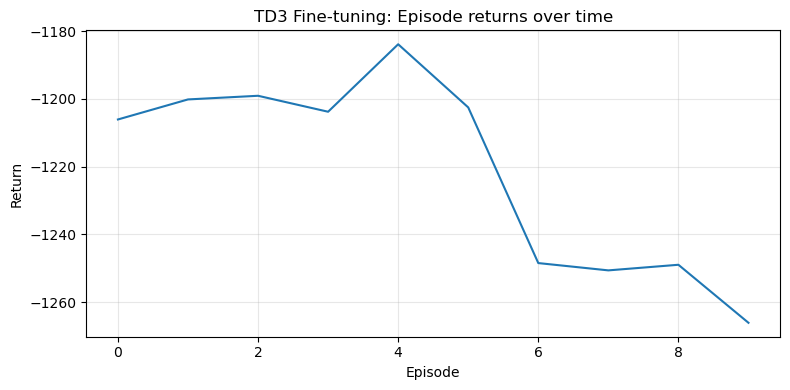

In [11]:
# plot learning curves
plt.figure(figsize=(8,4))
plt.plot(logs['episode_returns'])
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('TD3 Fine-tuning: Episode returns over time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
i = 0

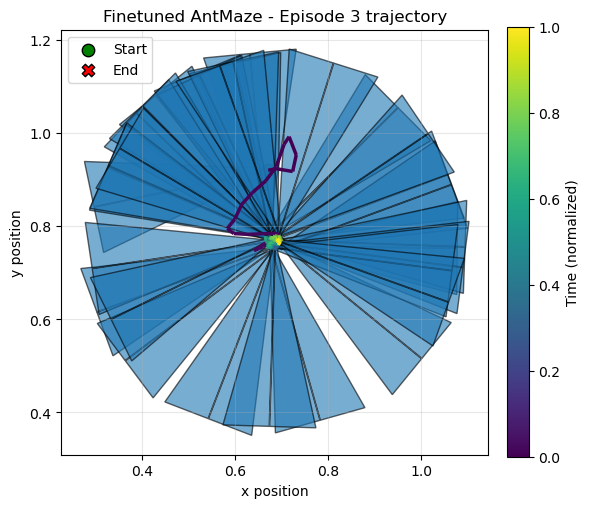

In [16]:
fig, ax = plot_ant_trajectory_xy(ft_records, episode_id=i % 10, title_prefix='Finetuned AntMaze')
plt.show()
i += 1